# NoSQL i Big Data analitika - projektni zadatak

Student: Patrik Sadaić

JMBAG: 0246061195

Dataset: **Parkinsons Telemonitoring Data Set** (https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring)

#### Opis podataka
- korišteni dataset je skup biomedicinskih parametara zabilježenih na snimkama govora kod pojedinaca u početnom stadiju Parkinsonove bolesti
- uzorci su prikupljeni od 42 pacijenta koji su kontiunirano pračeni kroz 6 mjeseci istraživanja te je za svakog pacijenta zabiljezeno oko 200 snimaka
- cilj ovog seta podataka je dokazivanje poveznice između promjena parametara govornih snimaka pacijenata i određivanja stadija uznapredovalosti Parkinsonove bolesti (UPDRS vrijednosti)

In [1]:
%matplotlib inline

# Imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

In [2]:
# Define data header.
header = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)',
          'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)',
          'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE',
          'DFA', 'PPE'
         ]

# Define categorical variables.
categorical = ['age', 'bin_age', 'sex']

# Define continuous variables.
continuous = ['test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP',
              'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
              'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'
             ]

# Read data.
data = pd.read_csv('../data/parkinsons_updrs.data',
                   header=None,
                   names=header,
                   skiprows=1,
                   encoding='iso-8859-1',
                   sep=',')

# Remove unneeded data.
del data['subject#']

data.head()

age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  Jitter(Abs)  \
0   72    0     5.6431       28.199       34.398    0.00662     0.000034   
1   72    0    12.6660       28.447       34.894    0.00300     0.000017   
2   72    0    19.6810       28.695       35.389    0.00481     0.000025   
3   72    0    25.6470       28.905       35.810    0.00528     0.000027   
4   72    0    33.6420       29.187       36.375    0.00335     0.000020   

   Jitter:RAP  Jitter:PPQ5  Jitter:DDP  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.00401      0.00317     0.01204  ...        0.230       0.01438   
1     0.00132      0.00150     0.00395  ...        0.179       0.00994   
2     0.00205      0.00208     0.00616  ...        0.181       0.00734   
3     0.00191      0.00264     0.00573  ...        0.327       0.01106   
4     0.00093      0.00130     0.00278  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01309        0.01662      0.04314  0.014290  21.640  0.41888   
1       0.01072        0.01689      0.02982  0.011112  27.183  0.43493   
2       0.00844        0.01458      0.02202  0.020220  23.047  0.46222   
3       0.01265        0.01963      0.03317  0.027837  24.445  0.48730   
4       0.00929        0.01819      0.02036  0.011625  26.126  0.47188   

       DFA      PPE  
0  0.54842  0.16006  
1  0.56477  0.10810  
2  0.54405  0.21014  
3  0.57794  0.33277  
4  0.56122  0.19361  

[5 rows x 21 columns]

In [3]:
# Display dataset info.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 21 columns):
age              5875 non-null int64
sex              5875 non-null int64
test_time        5875 non-null float64
motor_UPDRS      5875 non-null float64
total_UPDRS      5875 non-null float64
Jitter(%)        5875 non-null float64
Jitter(Abs)      5875 non-null float64
Jitter:RAP       5875 non-null float64
Jitter:PPQ5      5875 non-null float64
Jitter:DDP       5875 non-null float64
Shimmer          5875 non-null float64
Shimmer(dB)      5875 non-null float64
Shimmer:APQ3     5875 non-null float64
Shimmer:APQ5     5875 non-null float64
Shimmer:APQ11    5875 non-null float64
Shimmer:DDA      5875 non-null float64
NHR              5875 non-null float64
HNR              5875 non-null float64
RPDE             5875 non-null float64
DFA              5875 non-null float64
PPE              5875 non-null float64
dtypes: float64(19), int64(2)
memory usage: 963.9 KB


## 1. Kontrola kvalitete podataka

### 1.1. Prepoznavanje nedostajućih vrijednosti

In [4]:
# Sum null values by column.
data.isnull().sum()

age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

### 1.2. Rekodiranje nedostajućih vrijednosti

In [5]:
# Fill null values with 'Missing'.
data.fillna('Missing')

age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  Jitter(Abs)  \
0      72    0    5.64310       28.199       34.398    0.00662     0.000034   
1      72    0   12.66600       28.447       34.894    0.00300     0.000017   
2      72    0   19.68100       28.695       35.389    0.00481     0.000025   
3      72    0   25.64700       28.905       35.810    0.00528     0.000027   
4      72    0   33.64200       29.187       36.375    0.00335     0.000020   
5      72    0   40.65200       29.435       36.870    0.00353     0.000023   
6      72    0   47.64900       29.682       37.363    0.00422     0.000024   
7      72    0   54.64000       29.928       37.857    0.00476     0.000025   
8      72    0   61.66900       30.177       38.353    0.00432     0.000029   
9      72    0   68.68800       30.424       38.849    0.00496     0.000027   
10     72    0   75.65300       30.670       39.340    0.00465     0.000026   
11     72    0   82.65300       30.917       39.834    0.00537     0.000032   
12     72    0   89.63500       31.309       40.412    0.00524     0.000033   
13     72    0   96.63300       31.776       41.034    0.00354     0.000024   
14     72    0  103.64000       32.243       41.657    0.00530     0.000032   
15     72    0  110.65000       32.710       42.280    0.00456     0.000029   
16     72    0  117.66000       33.178       42.904    0.00693     0.000039   
17     72    0  124.64000       33.643       43.524    0.00652     0.000038   
18     72    0  131.64000       34.109       44.146    0.00571     0.000037   
19     72    0  139.69000       34.646       44.861    0.00372     0.000022   
20     72    0  145.64000       35.043       45.390    0.00285     0.000016   
21     72    0  152.64000       35.509       46.013    0.00629     0.000036   
22     72    0  159.64000       35.976       46.635    0.00375     0.000022   
23     72    0  174.66000       36.977       47.970    0.00386     0.000023   
24     72    0    5.64310       28.199       34.398    0.00348     0.000015   
25     72    0   12.66700       28.447       34.894    0.00950     0.000059   
26     72    0   19.68200       28.695       35.389    0.00401     0.000024   
27     72    0   25.64700       28.905       35.810    0.00340     0.000021   
28     72    0   33.64300       29.187       36.375    0.00317     0.000017   
29     72    0   40.65200       29.435       36.870    0.00471     0.000028   
...   ...  ...        ...          ...          ...        ...          ...   
5845   61    0  142.79000       22.485       33.485    0.00373     0.000030   
5846   61    0  149.84000       21.988       32.988    0.00233     0.000020   
5847   61    0  156.82000       21.495       32.495    0.00407     0.000030   
5848   61    0  163.73000       21.007       32.007    0.00250     0.000018   
5849   61    0  170.73000       20.513       31.513    0.00269     0.000021   
5850   61    0   -4.25970       19.725       28.634    0.00352     0.000027   
5851   61    0    0.39931       20.026       29.034    0.00742     0.000065   
5852   61    0    9.71390       20.627       29.836    0.00330     0.000025   
5853   61    0   16.71100       21.078       30.438    0.00239     0.000018   
5854   61    0   23.76100       21.533       31.044    0.00541     0.000041   
5855   61    0   30.64500       21.977       31.636    0.00203     0.000016   
5856   61    0   37.77200       22.437       32.249    0.00277     0.000022   
5857   61    0   44.64000       22.880       32.840    0.00549     0.000047   
5858   61    0   51.76200       23.339       33.453    0.00274     0.000020   
5859   61    0   58.76200       23.791       34.055    0.00541     0.000044   
5860   61    0   65.75700       24.242       34.657    0.00306     0.000025   
5861   61    0   79.77700       25.147       35.863    0.00335     0.000029   
5862   61    0   86.76700       25.598       36.464    0.00225     0.000017   
5863   61    0   93.54600       25.961       36.961    0

### 1.3. Prepoznavanje uniformnih ili nelogičnih distribucija

<Figure size 432x288 with 0 Axes>

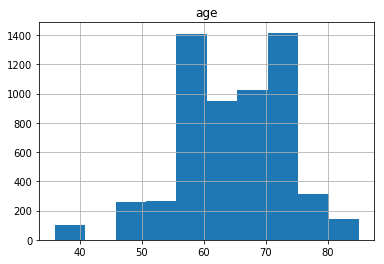

<Figure size 432x288 with 0 Axes>

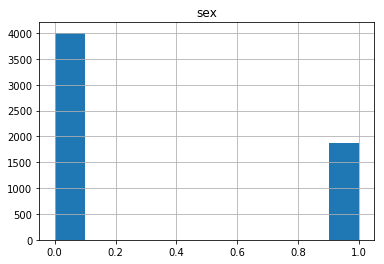

<Figure size 432x288 with 0 Axes>

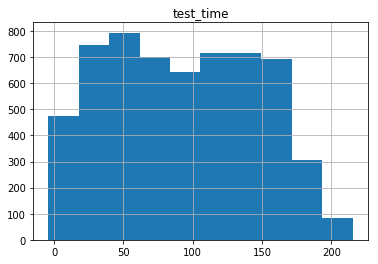

<Figure size 432x288 with 0 Axes>

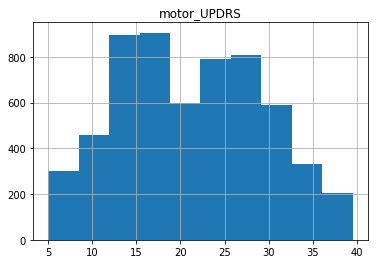

<Figure size 432x288 with 0 Axes>

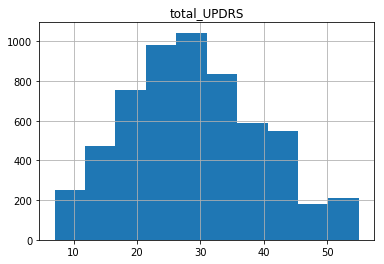

<Figure size 432x288 with 0 Axes>

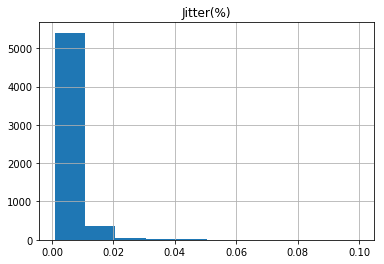

<Figure size 432x288 with 0 Axes>

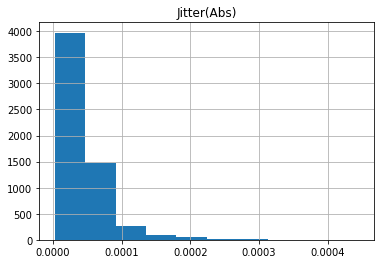

<Figure size 432x288 with 0 Axes>

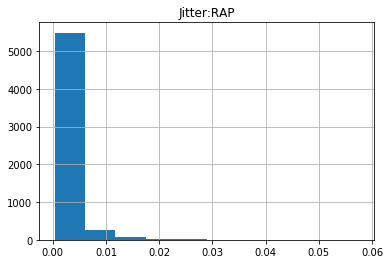

<Figure size 432x288 with 0 Axes>

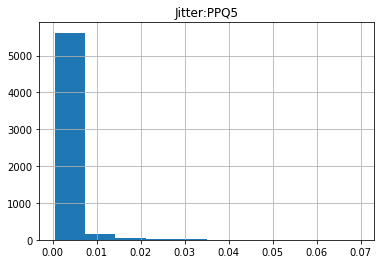

<Figure size 432x288 with 0 Axes>

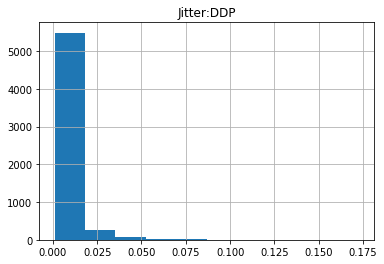

<Figure size 432x288 with 0 Axes>

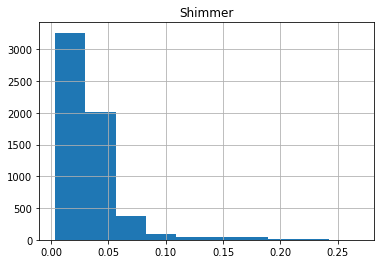

<Figure size 432x288 with 0 Axes>

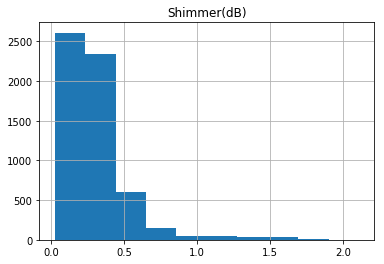

<Figure size 432x288 with 0 Axes>

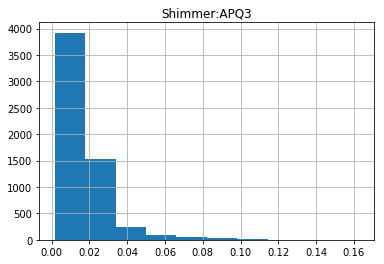

<Figure size 432x288 with 0 Axes>

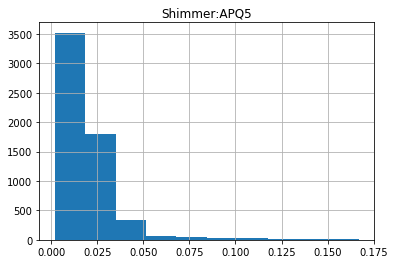

<Figure size 432x288 with 0 Axes>

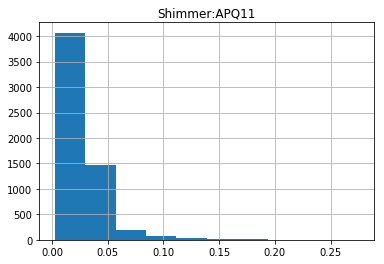

<Figure size 432x288 with 0 Axes>

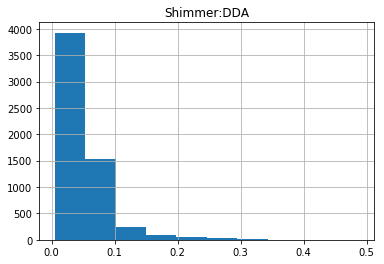

<Figure size 432x288 with 0 Axes>

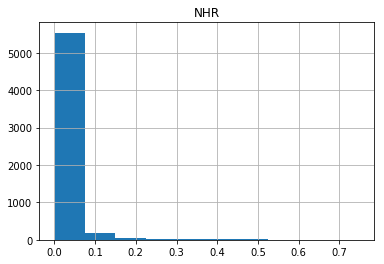

<Figure size 432x288 with 0 Axes>

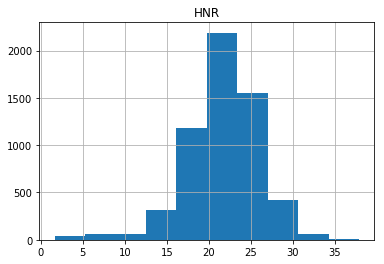

<Figure size 432x288 with 0 Axes>

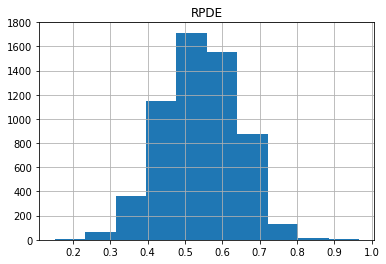

<Figure size 432x288 with 0 Axes>

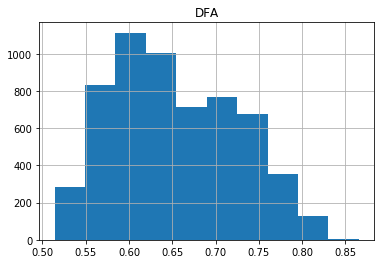

<Figure size 432x288 with 0 Axes>

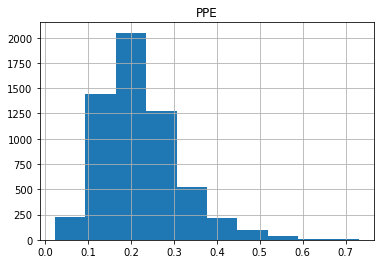

In [6]:
# Display distribution histogram for each column.
for column in data:
    plt.figure()
    data.hist([column])

### 1.4. Provjeriti / redizajnirati / odrediti ciljnu varijablu i njenu kvalitetu

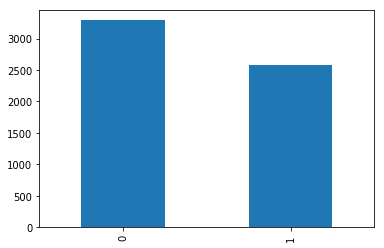

age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  Jitter(Abs)  \
0   72    0     5.6431       28.199       34.398    0.00662     0.000034   
1   72    0    12.6660       28.447       34.894    0.00300     0.000017   
2   72    0    19.6810       28.695       35.389    0.00481     0.000025   
3   72    0    25.6470       28.905       35.810    0.00528     0.000027   
4   72    0    33.6420       29.187       36.375    0.00335     0.000020   

   Jitter:RAP  Jitter:PPQ5  Jitter:DDP  ...  Shimmer:APQ5  Shimmer:APQ11  \
0     0.00401      0.00317     0.01204  ...       0.01309        0.01662   
1     0.00132      0.00150     0.00395  ...       0.01072        0.01689   
2     0.00205      0.00208     0.00616  ...       0.00844        0.01458   
3     0.00191      0.00264     0.00573  ...       0.01265        0.01963   
4     0.00093      0.00130     0.00278  ...       0.00929        0.01819   

   Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE   bin_age  \
0      0.04314  0.014290  21.640  0.41888  0.54842  0.16006  (69, 75]   
1      0.02982  0.011112  27.183  0.43493  0.56477  0.10810  (69, 75]   
2      0.02202  0.020220  23.047  0.46222  0.54405  0.21014  (69, 75]   
3      0.03317  0.027837  24.445  0.48730  0.57794  0.33277  (69, 75]   
4      0.02036  0.011625  26.126  0.47188  0.56122  0.19361  (69, 75]   

   moderate_disability  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  

[5 rows x 23 columns]

In [7]:
target_variable_values = []

# Calculate target variable.
for index, row in data.iterrows():
    if(row['motor_UPDRS'] >= 23 and row['total_UPDRS'] >= 27):
        target_variable_values.append(1)
    else:
        target_variable_values.append(0)

# Split categorical to bins.
for column in data:
    if(column == 'age'):
        data['bin_age'] = pd.cut(data['age'], bins=[32, 51, 57, 63, 69, 75, 81, 100])
    
# Insert target variable values into dataset.
data.insert(len(data.columns), "moderate_disability", target_variable_values, True)

# Plot target variable distribution.
plt.figure()
data.loc[:,data.columns[len(data.columns)-1]].value_counts().plot.bar()
plt.show()
data.head()

## 2. Statističke analize uzorka podataka

### 2.1. Za svaku kategoričku varijablu prikazati distribuciju frekvencije u grafu

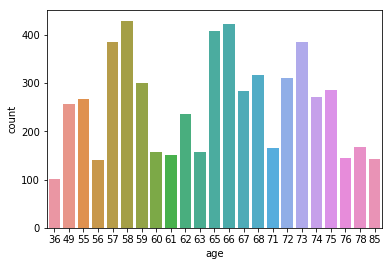

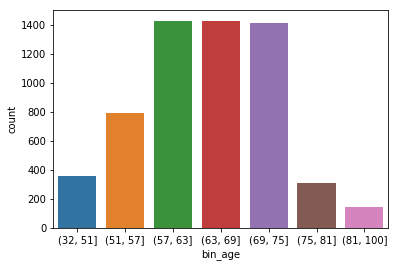

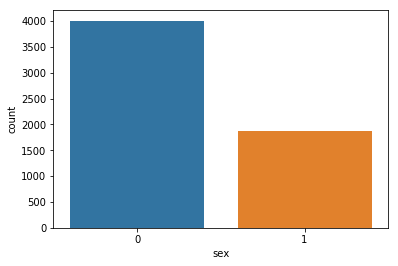

In [8]:
# Visualize categorical variables.
for column in categorical:
    plt.figure()
    sns.countplot(x=column,data=data)

### 2.2. Za svaku kontinuiranu varijablu izračunati srednju vrijednost, z vrijednosti, zaobljenost distribucije, nagnutost distribucije

In [9]:
# Print mean, kurtosis, skew, zScore values for continuous variables values.
for column in continuous:
    value=data[column]
    
    mean = np.mean(value)
    kurtosis = stats.kurtosis(value)
    skew = stats.skew(value)
    zScore = stats.zscore(value)

    print(column)
    print('Mean: {}'.format(mean))
    print('Kurtosis: {}'.format(kurtosis))
    print('Skew: {}'.format(stats.skew(value)))
    print('zScore: {}'.format(zScore))
    print('\n')

test_time
Mean: 92.8637220459577
Kurtosis: -1.1474220627719964
Skew: 0.07770034559856029
zScore: [-1.63209025 -1.5006763  -1.36941017 ...  1.19676305  1.32606439
  1.45704984]


motor_UPDRS
Mean: 21.296228544680908
Kurtosis: -0.937746890905419
Skew: 0.07522906523658138
zScore: [ 0.84919669  0.87970629  0.91021589 ...  0.02445338 -0.03558164
 -0.09635479]


total_UPDRS
Mean: 29.01894228085111
Kurtosis: -0.3564219764051635
Skew: 0.27098413559961604
zScore: [0.50274516 0.54910301 0.59536741 ... 0.32488426 0.27927411 0.23310318]


Jitter(%)
Mean: 0.006153761702127647
Kurtosis: 67.4381079043843
Skew: 6.450198350235463
zScore: [ 0.08290524 -0.56079341 -0.23894409 ... -0.47366293 -0.5945787
 -0.59280052]


Jitter(Abs)
Mean: 4.402711829787217e-05
Kurtosis: 18.139132323903365
Skew: 3.282237140113735
zScore: [-0.28424219 -0.75672302 -0.53938184 ... -0.5371584  -0.65833584
 -0.63721316]


Jitter:RAP
Mean: 0.00298718468085105
Kurtosis: 78.46673777050069
Skew: 6.943664547586852
zScore: [ 0.32745251

### 2.3. Izračunati korelacije svake varijable s ciljnom varijablom

In [10]:
# Display data correlations.
data.corr()

age       sex  test_time  motor_UPDRS  total_UPDRS  \
age                  1.000000 -0.041602   0.019884     0.273665     0.310290   
sex                 -0.041602  1.000000  -0.009805    -0.031205    -0.096559   
test_time            0.019884 -0.009805   1.000000     0.067918     0.075263   
motor_UPDRS          0.273665 -0.031205   0.067918     1.000000     0.947231   
total_UPDRS          0.310290 -0.096559   0.075263     0.947231     1.000000   
Jitter(%)            0.023071  0.051422  -0.022837     0.084816     0.074247   
Jitter(Abs)          0.035691 -0.154645  -0.011365     0.050903     0.066927   
Jitter:RAP           0.010255  0.076718  -0.028888     0.072684     0.064015   
Jitter:PPQ5          0.013199  0.087995  -0.023290     0.076291     0.063352   
Jitter:DDP           0.010258  0.076703  -0.028876     0.072698     0.064027   
Shimmer              0.101554  0.058736  -0.033870     0.102349     0.092141   
Shimmer(dB)          0.111130  0.056481  -0.030962     0.110076     0.098790   
Shimmer:APQ3         0.098912  0.044937  -0.029020     0.084261     0.079363   
Shimmer:APQ5         0.089983  0.064819  -0.036504     0.092105     0.083467   
Shimmer:APQ11        0.135238  0.023360  -0.039110     0.136560     0.120838   
Shimmer:DDA          0.098913  0.044938  -0.029017     0.084260     0.079363   
NHR                  0.007093  0.168170  -0.026357     0.074967     0.060952   
HNR                 -0.104842 -0.000167   0.036545    -0.157029    -0.162117   
RPDE                 0.090208 -0.159262  -0.038887     0.128607     0.156897   
DFA                 -0.092870 -0.165113   0.019261    -0.116242    -0.113475   
PPE                  0.120790 -0.099901  -0.000563     0.162433     0.156195   
moderate_disability  0.197258 -0.032254  -0.033509     0.850973     0.798360   

                     Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
age                   0.023071     0.035691    0.010255     0.013199   
sex                   0.051422    -0.154645    0.076718     0.087995   
test_time            -0.022837    -0.011365   -0.028888    -0.023290   
motor_UPDRS           0.084816     0.050903    0.072684     0.076291   
total_UPDRS           0.074247     0.066927    0.064015     0.063352   
Jitter(%)             1.000000     0.865577    0.984181     0.968214   
Jitter(Abs)           0.865577     1.000000    0.844626     0.790538   
Jitter:RAP            0.984181     0.844626    1.000000     0.947196   
Jitter:PPQ5           0.968214     0.790538    0.947196     1.000000   
Jitter:DDP            0.984184     0.844630    1.000000     0.947203   
Shimmer               0.709791     0.649046    0.681729     0.732747   
Shimmer(dB)           0.716704     0.655871    0.685551     0.734591   
Shimmer:APQ3          0.664149     0.623830    0.650226     0.676711   
Shimmer:APQ5          0.694002     0.621401    0.659831     0.734021   
Shimmer:APQ11         0.645965     0.589998    0.603082     0.668413   
Shimmer:DDA           0.664147     0.623827    0.650225     0.676710   
NHR                   0.825294     0.699960    0.792373     0.864864   
HNR                  -0.675188    -0.706418   -0.641473    -0.662409   
RPDE                  0.427128     0.547100    0.382891     0.381503   
DFA                   0.226550     0.352264    0.214881     0.175359   
PPE                   0.721849     0.787853    0.670652     0.663491   
moderate_disability   0.051816     0.019359    0.042145     0.049855   

                     Jitter:DDP  ...  Shimmer:APQ3  Shimmer:APQ5  \
age                    0.010258  ...      0.098912      0.089983   
sex                    0.076703  ...      0.044937      0.064819   
test_time             -0.028876  ...     -0.029020     -0.036504   
motor_UPDRS            0.072698  ...      0.084261      0.092105   
total_UPDRS            0.064027  ...      0.079363      0.083467   
Jitter(%)              0.984184  ...      0.664149      0.694002   
Jitter(Abs)            0.844630  ...      0.623830  

### 2.4. Izračunati korelacije svake varijable izražene kroz Z vrijednost i kategorizirane u razrede <-3, (-3 do 3), >3 s ciljnom varijablom

In [11]:
zData = data.copy()
bin_zData = data.copy()

# Define Z-score bins.
bins =[-np.inf, -3, 3, np.inf]

for column in zData:
    value = zData[column]
    del zData[column]
    del bin_zData[column]
    
    # Skip categorical.
    if column in categorical:
        continue
        
    # Just copy target value.
    if (column == 'moderate_disability'):
        zData[column] = value
        continue
        
    # Calculate Z-score
    zColumn = column + '_zScore'
    zScore = (value - value.mean())/value.std(ddof=0)
    zData[zColumn] = zScore
    
    # Cut Z-score into bins.
    bin_zData[zColumn] = pd.cut(zScore, bins, include_lowest=True)

In [12]:
# Preview Z-data
zData.head()

test_time_zScore  motor_UPDRS_zScore  total_UPDRS_zScore  Jitter(%)_zScore  \
0         -1.632090            0.849197            0.502745          0.082905   
1         -1.500676            0.879706            0.549103         -0.560793   
2         -1.369410            0.910216            0.595367         -0.238944   
3         -1.257773            0.936051            0.634716         -0.155370   
4         -1.108169            0.970743            0.687522         -0.498557   

   Jitter(Abs)_zScore  Jitter:RAP_zScore  Jitter:PPQ5_zScore  \
0           -0.284242           0.327453           -0.028637   
1           -0.756723          -0.533746           -0.476212   
2           -0.539382          -0.300038           -0.320767   
3           -0.485186          -0.344859           -0.170682   
4           -0.663894          -0.658604           -0.529814   

   Jitter:DDP_zScore  Shimmer_zScore  Shimmer(dB)_zScore  Shimmer:APQ3_zScore  \
0           0.328505       -0.324594           -0.351642            -0.209709   
1          -0.534825       -0.534016           -0.573156            -0.545158   
2          -0.298983       -0.669115           -0.564469            -0.741592   
3          -0.344871       -0.423692            0.069668            -0.460540   
4          -0.659682       -0.658276           -0.586186            -0.783145   

   Shimmer:APQ5_zScore  Shimmer:APQ11_zScore  Shimmer:DDA_zScore  NHR_zScore  \
0            -0.423356             -0.543466           -0.209704   -0.298721   
1            -0.565592             -0.529955           -0.545153   -0.351965   
2            -0.702426             -0.645545           -0.741587   -0.199370   
3            -0.449763             -0.392849           -0.460787   -0.071754   
4            -0.651413             -0.464905           -0.783392   -0.343370   

   HNR_zScore  RPDE_zScore  DFA_zScore  PPE_zScore  moderate_disability  
0   -0.009205    -1.214066   -1.478500   -0.650658                    1  
1    1.282650    -1.055119   -1.247880   -1.218585                    1  
2    0.318711    -0.784860   -1.540139   -0.103280                    1  
3    0.644530    -0.536487   -1.062115    1.237075                    1  
4    1.036305    -0.689195   -1.297953   -0.283954                    1

In [13]:
# Preview binned Z-data.
bin_zData.head()

test_time_zScore motor_UPDRS_zScore total_UPDRS_zScore Jitter(%)_zScore  \
0      (-3.0, 3.0]        (-3.0, 3.0]        (-3.0, 3.0]      (-3.0, 3.0]   
1      (-3.0, 3.0]        (-3.0, 3.0]        (-3.0, 3.0]      (-3.0, 3.0]   
2      (-3.0, 3.0]        (-3.0, 3.0]        (-3.0, 3.0]      (-3.0, 3.0]   
3      (-3.0, 3.0]        (-3.0, 3.0]        (-3.0, 3.0]      (-3.0, 3.0]   
4      (-3.0, 3.0]        (-3.0, 3.0]        (-3.0, 3.0]      (-3.0, 3.0]   

  Jitter(Abs)_zScore Jitter:RAP_zScore Jitter:PPQ5_zScore Jitter:DDP_zScore  \
0        (-3.0, 3.0]       (-3.0, 3.0]        (-3.0, 3.0]       (-3.0, 3.0]   
1        (-3.0, 3.0]       (-3.0, 3.0]        (-3.0, 3.0]       (-3.0, 3.0]   
2        (-3.0, 3.0]       (-3.0, 3.0]        (-3.0, 3.0]       (-3.0, 3.0]   
3        (-3.0, 3.0]       (-3.0, 3.0]        (-3.0, 3.0]       (-3.0, 3.0]   
4        (-3.0, 3.0]       (-3.0, 3.0]        (-3.0, 3.0]       (-3.0, 3.0]   

  Shimmer_zScore Shimmer(dB)_zScore Shimmer:APQ3_zScore Shimmer:APQ5_zScore  \
0    (-3.0, 3.0]        (-3.0, 3.0]         (-3.0, 3.0]         (-3.0, 3.0]   
1    (-3.0, 3.0]        (-3.0, 3.0]         (-3.0, 3.0]         (-3.0, 3.0]   
2    (-3.0, 3.0]        (-3.0, 3.0]         (-3.0, 3.0]         (-3.0, 3.0]   
3    (-3.0, 3.0]        (-3.0, 3.0]         (-3.0, 3.0]         (-3.0, 3.0]   
4    (-3.0, 3.0]        (-3.0, 3.0]         (-3.0, 3.0]         (-3.0, 3.0]   

  Shimmer:APQ11_zScore Shimmer:DDA_zScore   NHR_zScore   HNR_zScore  \
0          (-3.0, 3.0]        (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]   
1          (-3.0, 3.0]        (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]   
2          (-3.0, 3.0]        (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]   
3          (-3.0, 3.0]        (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]   
4          (-3.0, 3.0]        (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]   

   RPDE_zScore   DFA_zScore   PPE_zScore  
0  (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]  
1  (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]  
2  (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]  
3  (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]  
4  (-3.0, 3.0]  (-3.0, 3.0]  (-3.0, 3.0]

In [14]:
# Display Z-score correlations.
zData.corr()

test_time_zScore  motor_UPDRS_zScore  \
test_time_zScore              1.000000            0.067918   
motor_UPDRS_zScore            0.067918            1.000000   
total_UPDRS_zScore            0.075263            0.947231   
Jitter(%)_zScore             -0.022837            0.084816   
Jitter(Abs)_zScore           -0.011365            0.050903   
Jitter:RAP_zScore            -0.028888            0.072684   
Jitter:PPQ5_zScore           -0.023290            0.076291   
Jitter:DDP_zScore            -0.028876            0.072698   
Shimmer_zScore               -0.033870            0.102349   
Shimmer(dB)_zScore           -0.030962            0.110076   
Shimmer:APQ3_zScore          -0.029020            0.084261   
Shimmer:APQ5_zScore          -0.036504            0.092105   
Shimmer:APQ11_zScore         -0.039110            0.136560   
Shimmer:DDA_zScore           -0.029017            0.084260   
NHR_zScore                   -0.026357            0.074967   
HNR_zScore                    0.036545           -0.157029   
RPDE_zScore                  -0.038887            0.128607   
DFA_zScore                    0.019261           -0.116242   
PPE_zScore                   -0.000563            0.162433   
moderate_disability          -0.033509            0.850973   

                      total_UPDRS_zScore  Jitter(%)_zScore  \
test_time_zScore                0.075263         -0.022837   
motor_UPDRS_zScore              0.947231          0.084816   
total_UPDRS_zScore              1.000000          0.074247   
Jitter(%)_zScore                0.074247          1.000000   
Jitter(Abs)_zScore              0.066927          0.865577   
Jitter:RAP_zScore               0.064015          0.984181   
Jitter:PPQ5_zScore              0.063352          0.968214   
Jitter:DDP_zScore               0.064027          0.984184   
Shimmer_zScore                  0.092141          0.709791   
Shimmer(dB)_zScore              0.098790          0.716704   
Shimmer:APQ3_zScore             0.079363          0.664149   
Shimmer:APQ5_zScore             0.083467          0.694002   
Shimmer:APQ11_zScore            0.120838          0.645965   
Shimmer:DDA_zScore              0.079363          0.664147   
NHR_zScore                      0.060952          0.825294   
HNR_zScore                     -0.162117         -0.675188   
RPDE_zScore                     0.156897          0.427128   
DFA_zScore                     -0.113475          0.226550   
PPE_zScore                      0.156195          0.721849   
moderate_disability             0.798360          0.051816   

                      Jitter(Abs)_zScore  Jitter:RAP_zScore  \
test_time_zScore               -0.011365          -0.028888   
motor_UPDRS_zScore              0.050903           0.072684   
total_UPDRS_zScore              0.066927           0.064015   
Jitter(%)_zScore                0.865577           0.984181   
Jitter(Abs)_zScore              1.000000           0.844626   
Jitter:RAP_zScore               0.844626           1.000000   
Jitter:PPQ5_zScore              0.790538           0.947196   
Jitter:DDP_zScore               0.844630           1.000000   
Shimmer_zScore                  0.649046           0.681729   
Shimmer(dB)_zScore              0.655871           0.685551   
Shimmer:APQ3_zScore             0.623830           0.650226   
Shimmer:APQ5_zScore             0.621401           0.659831   
Shimmer:APQ11_zScore            0.589998           0.603082   
Shimmer:DDA_zScore              0.623827           0.650225   
NHR_zScore                      0.699960           0.792373   
HNR_zScore                     -0.706418          -0.641473   
RPDE_zScore                     0.547100           0.382891   
DFA_zScore                      0.352264           0.214881   
PPE_zScore                      0.787853           0.670652   
moderate_disability             0.019359           0.042145   

                      Jitter:PPQ5_zScore  Jitter:DDP_zScore  Shimmer_zScore  \
test_time_zSc

### 2.5. Objasniti što ste spoznali vezano uz promatrani skup podataka temeljem analiza iz točke 2

#### moderate_disablility
- kao ciljna varijabla kreirana je i odabrana vrijednost **moderate_disablity**
- vrijednost ciljne varijable određena je vrijednostima **motor_UPDRS** i **total_UPDRS** parametara, tj. ako je vrijednost **motor_UPDRS** parametra veća od **23** te vrijednost **total_UPDRS** parametra veća od **27** vrijednost ciljne varijable biti će 1, dok je u protivnom vrijednost jednaka 0.
- vrijednost **UPDRS** parametara označava stupanj uznapredovalosti Parkinsonove bolesti
- tražene vrijednosti **UPDRS** parametara odabrane su na temelju nekoliko medicinskih članaka u kojima se navodi kako su to prosječne vrijednosti koje određuju pojavu umjerene invalidnosti kod pacijenata oboljelih od Parkinsonove bolesti

#### age
- većina uzorka nalazi se između 57 i 75 godina
- pozitivno korelira sa ciljnom varijablom, tj. starije osobe su sklonije umjerenoj ili ozbiljnijoj invalidnosti

#### sex
- muškarci su skloniji pojavi Parkinsonove bolesti te samim time i umjerenoj invalidnosti
- gotovo dvostruko veći broj muškaraca prisutno u uzorku u odnosu na žene
- negativna korelacija, tj. žene imaju manju vjerojatnost oboljevanja od Parkinsonove bolesti te im je uglavnom potrebno više vremena da razviju umjerenu invalidnost

#### Jitter i Shimmer vrijednosti
- obje grupe vrijednosti označavaju određene smetnje i odstupanja parametara govora od normalnih vrijednost prisutnih kod zdravih pojedinaca
- navedene vrijednosti pozitivno koreliraju sa ciljnom varijablom, veće vrijednosti (odstupanja) doprinose razvijanju invalidnosti

#### ostalo
- ostale vrijednosti u zanemarivoj mjeri utječu na ciljnu varijablu te ih nije potrebno dodatno komentirati

## 3. IV, WoE izračuni

### 3.1. Izračunati IV, WoE za svaku varijablu

In [15]:
def woe_iv_calculation(dataset, feature, target, sort=False):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append(OrderedDict({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            
        }))
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    if(sort==True):
        # Sort values (useful for bins).
        dset.sort_values(by=['Value'],inplace=True)
        
    return dset, iv

for col in data.columns:
    # Skip target variable.
    if col == 'moderate_disability': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        # Calculate WoE, IV.
        woe, iv = woe_iv_calculation(data, col, 'moderate_disability')
        print(woe)
        print(col)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: age
    Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE            IV
0      72  310   149  161    0.057618   0.048951  0.163013  1.412818e-03
1      58  429     0  429    0.000000   0.130435  0.000000 -0.000000e+00
2      57  385   132  253    0.051044   0.076923 -0.410116  1.061340e-02
3      74  271   122  149    0.047177   0.045303  0.040546  7.600693e-05
4      75  286   250   36    0.096674   0.010946  2.178413  1.867528e-01
5      63  156   156    0    0.060325   0.000000  0.000000  0.000000e+00
6      73  385   153  232    0.059165   0.070538 -0.175828  1.999768e-03
7      68  317   165  152    0.063805   0.046215  0.322536  5.673557e-03
8      55  267     0  267    0.000000   0.081180  0.000000 -0.000000e+00
9      62  236    87  149    0.033643   0.045303 -0.297567  3.469580e-03
10     65  407     0  407    0.000000   0.123746  0.000000 -0.000000e+00
11     66  422   380   42    0.146945   0.012770  2.442973  3.277865e-01
12     67  283     0  28

       Value  All  Good  Bad  Distr_Good  Distr_Bad  WoE   IV
0     34.398    4     4    0    0.001547   0.000000  0.0  0.0
1     34.894    6     6    0    0.002320   0.000000  0.0  0.0
2     35.389    5     5    0    0.001933   0.000000  0.0  0.0
3     35.810    3     3    0    0.001160   0.000000  0.0  0.0
4     36.375    6     6    0    0.002320   0.000000  0.0  0.0
5     36.870    6     6    0    0.002320   0.000000  0.0  0.0
6     37.363    3     3    0    0.001160   0.000000  0.0  0.0
7     37.857    6     6    0    0.002320   0.000000  0.0  0.0
8     38.353    6     6    0    0.002320   0.000000  0.0  0.0
9     38.849    6     6    0    0.002320   0.000000  0.0  0.0
10    39.340    6     6    0    0.002320   0.000000  0.0  0.0
11    39.834    3     3    0    0.001160   0.000000  0.0  0.0
12    40.412    6     6    0    0.002320   0.000000  0.0  0.0
13    41.034    6     6    0    0.002320   0.000000  0.0  0.0
14    41.657    6     6    0    0.002320   0.000000  0.0  0.0
15    42

         Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0     0.000034    2     2    0    0.000773   0.000000  0.000000  0.000000
1     0.000017    3     3    0    0.001160   0.000000  0.000000  0.000000
2     0.000025    3     2    1    0.000773   0.000304  0.933618  0.000438
3     0.000027    5     4    1    0.001547   0.000304  1.626766  0.002022
4     0.000020    3     1    2    0.000387   0.000608 -0.452676  0.000100
5     0.000023    2     1    1    0.000387   0.000304  0.240471  0.000020
6     0.000024    1     1    0    0.000387   0.000000  0.000000  0.000000
7     0.000025    1     1    0    0.000387   0.000000  0.000000  0.000000
8     0.000029    3     2    1    0.000773   0.000304  0.933618  0.000438
9     0.000027    3     1    2    0.000387   0.000608 -0.452676  0.000100
10    0.000026    3     2    1    0.000773   0.000304  0.933618  0.000438
11    0.000032    2     1    1    0.000387   0.000304  0.240471  0.000020
12    0.000033    2     1    1    0.00

       Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE            IV
0    0.00317   10     5    5    0.001933   0.001520  0.240471  9.937935e-05
1    0.00150   27    12   15    0.004640   0.004561  0.017328  1.381272e-06
2    0.00208   26    12   14    0.004640   0.004257  0.086321  3.312625e-05
3    0.00264   19     9   10    0.003480   0.003040  0.135111  5.942720e-05
4    0.00130   14     5    9    0.001933   0.002736 -0.347315  2.788616e-04
5    0.00159   21     7   14    0.002707   0.004257 -0.452676  7.015253e-04
6    0.00221   24     6   18    0.002320   0.005473 -0.858141  2.705377e-03
7    0.00259   21     6   15    0.002320   0.004561 -0.675819  1.514154e-03
8    0.00207   30    11   19    0.004254   0.005777 -0.306072  4.661967e-04
9    0.00253   29    14   15    0.005414   0.004561  0.171478  1.462899e-04
10   0.00260   22     8   14    0.003094   0.004257 -0.319145  3.711753e-04
11   0.00278   21    11   10    0.004254   0.003040  0.335781  4.073821e-04
12   0.00251

        Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0     0.02565    1     1    0    0.000387   0.000000  0.000000  0.000000
1     0.02024    2     1    1    0.000387   0.000304  0.240471  0.000020
2     0.01675    2     2    0    0.000773   0.000000  0.000000  0.000000
3     0.02309    2     1    1    0.000387   0.000304  0.240471  0.000020
4     0.01703    3     2    1    0.000773   0.000304  0.933618  0.000438
5     0.02227    3     2    1    0.000773   0.000304  0.933618  0.000438
6     0.04352    3     1    2    0.000387   0.000608 -0.452676  0.000100
7     0.02191    4     3    1    0.001160   0.000304  1.339084  0.001146
8     0.04296    2     1    1    0.000387   0.000304  0.240471  0.000020
9     0.03610    2     1    1    0.000387   0.000304  0.240471  0.000020
10    0.02132    1     1    0    0.000387   0.000000  0.000000  0.000000
11    0.02377    1     1    0    0.000387   0.000000  0.000000  0.000000
12    0.02493    2     1    1    0.000387   0.00030

        Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0     0.01438    3     1    2    0.000387   0.000608 -0.452676  0.000100
1     0.00994    4     1    3    0.000387   0.000912 -0.858141  0.000451
2     0.00734    1     1    0    0.000387   0.000000  0.000000  0.000000
3     0.01106    2     2    0    0.000773   0.000000  0.000000  0.000000
4     0.00679    6     4    2    0.001547   0.000608  0.933618  0.000876
5     0.01006    6     2    4    0.000773   0.001216 -0.452676  0.000200
6     0.02376    4     3    1    0.001160   0.000304  1.339084  0.001146
7     0.00979    3     2    1    0.000773   0.000304  0.933618  0.000438
8     0.01774    2     1    1    0.000387   0.000304  0.240471  0.000020
9     0.02030    2     2    0    0.000773   0.000000  0.000000  0.000000
10    0.01069    2     2    0    0.000773   0.000000  0.000000  0.000000
11    0.01001    2     1    1    0.000387   0.000304  0.240471  0.000020
12    0.01176    5     3    2    0.001160   0.00060

        Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0     0.01662    3     3    0    0.001160   0.000000  0.000000  0.000000
1     0.01689    4     2    2    0.000773   0.000608  0.240471  0.000040
2     0.01458    2     1    1    0.000387   0.000304  0.240471  0.000020
3     0.01963    3     1    2    0.000387   0.000608 -0.452676  0.000100
4     0.01819    4     3    1    0.001160   0.000304  1.339084  0.001146
5     0.02263    3     1    2    0.000387   0.000608 -0.452676  0.000100
6     0.03488    3     3    0    0.001160   0.000000  0.000000  0.000000
7     0.01911    5     3    2    0.001160   0.000608  0.645936  0.000357
8     0.03451    2     2    0    0.000773   0.000000  0.000000  0.000000
9     0.02569    4     2    2    0.000773   0.000608  0.240471  0.000040
10    0.01844    3     2    1    0.000773   0.000304  0.933618  0.000438
11    0.02395    1     1    0    0.000387   0.000000  0.000000  0.000000
12    0.02019    2     2    0    0.000773   0.00000

         Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE       IV
0     0.014290    2     2    0    0.000773   0.000000  0.000000  0.00000
1     0.011112    1     1    0    0.000387   0.000000  0.000000  0.00000
2     0.020220    1     1    0    0.000387   0.000000  0.000000  0.00000
3     0.027837    1     1    0    0.000387   0.000000  0.000000  0.00000
4     0.011625    1     1    0    0.000387   0.000000  0.000000  0.00000
5     0.009438    1     1    0    0.000387   0.000000  0.000000  0.00000
6     0.013260    1     1    0    0.000387   0.000000  0.000000  0.00000
7     0.027969    1     1    0    0.000387   0.000000  0.000000  0.00000
8     0.013381    1     1    0    0.000387   0.000000  0.000000  0.00000
9     0.018021    1     1    0    0.000387   0.000000  0.000000  0.00000
10    0.017443    1     1    0    0.000387   0.000000  0.000000  0.00000
11    0.017115    2     2    0    0.000773   0.000000  0.000000  0.00000
12    0.011876    1     1    0    0.000387   0.0000

        Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
0     0.41888    1     1    0    0.000387   0.000000  0.000000  0.000000
1     0.43493    1     1    0    0.000387   0.000000  0.000000  0.000000
2     0.46222    1     1    0    0.000387   0.000000  0.000000  0.000000
3     0.48730    2     2    0    0.000773   0.000000  0.000000  0.000000
4     0.47188    1     1    0    0.000387   0.000000  0.000000  0.000000
5     0.53949    2     1    1    0.000387   0.000304  0.240471  0.000020
6     0.49250    1     1    0    0.000387   0.000000  0.000000  0.000000
7     0.47712    1     1    0    0.000387   0.000000  0.000000  0.000000
8     0.51563    1     1    0    0.000387   0.000000  0.000000  0.000000
9     0.50032    2     1    1    0.000387   0.000304  0.240471  0.000020
10    0.49892    1     1    0    0.000387   0.000000  0.000000  0.000000
11    0.46686    1     1    0    0.000387   0.000000  0.000000  0.000000
12    0.56600    1     1    0    0.000387   0.00000

         Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE       IV
0     0.160060    1     1    0    0.000387   0.000000  0.000000  0.00000
1     0.108100    1     1    0    0.000387   0.000000  0.000000  0.00000
2     0.210140    1     1    0    0.000387   0.000000  0.000000  0.00000
3     0.332770    1     1    0    0.000387   0.000000  0.000000  0.00000
4     0.193610    1     1    0    0.000387   0.000000  0.000000  0.00000
5     0.195000    2     1    1    0.000387   0.000304  0.240471  0.00002
6     0.175630    1     1    0    0.000387   0.000000  0.000000  0.00000
7     0.238440    1     1    0    0.000387   0.000000  0.000000  0.00000
8     0.200370    1     1    0    0.000387   0.000000  0.000000  0.00000
9     0.201170    2     1    1    0.000387   0.000304  0.240471  0.00002
10    0.173870    2     2    0    0.000773   0.000000  0.000000  0.00000
11    0.193900    1     1    0    0.000387   0.000000  0.000000  0.00000
12    0.209840    1     1    0    0.000387   0.0000

### 3.2. Izdvojiti varijable s najjačim IV-om i prikazati grafički WoE graf za sve najjače varijable

In [16]:
def visualize_woe(dataset, feature, target):
    woe, iv = woe_iv_calculation(dataset, feature, target, True)
    print(feature)
    plt.figure()
    # Plot WoE value bar chart.
    sns.factorplot("Value",'WoE',data=woe,kind="bar",size=6,aspect=2,legend_out=False)
    
# Prepare woe dataset.
woeData = data.copy()

bin_age_2


<Figure size 432x288 with 0 Axes>

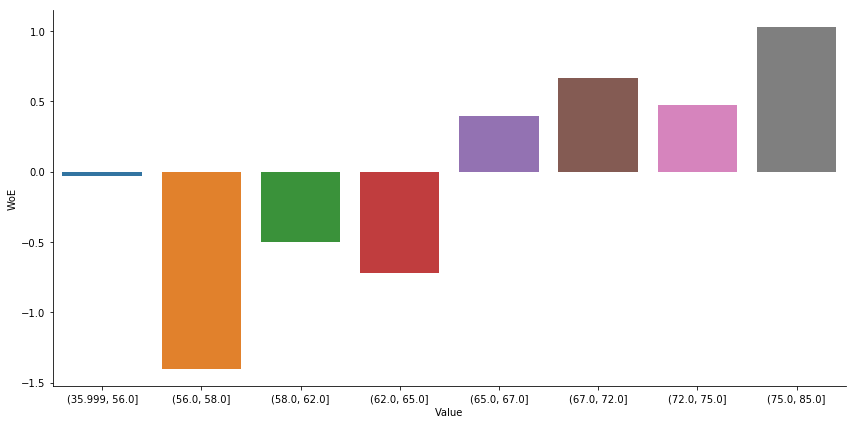

In [17]:
# Divide age to 8 bins, graph.
woeData['bin_age_2'] = (pd.qcut(data['age'],8))
visualize_woe(woeData, 'bin_age_2', 'moderate_disability')

bin_Jitter:DDP


<Figure size 432x288 with 0 Axes>

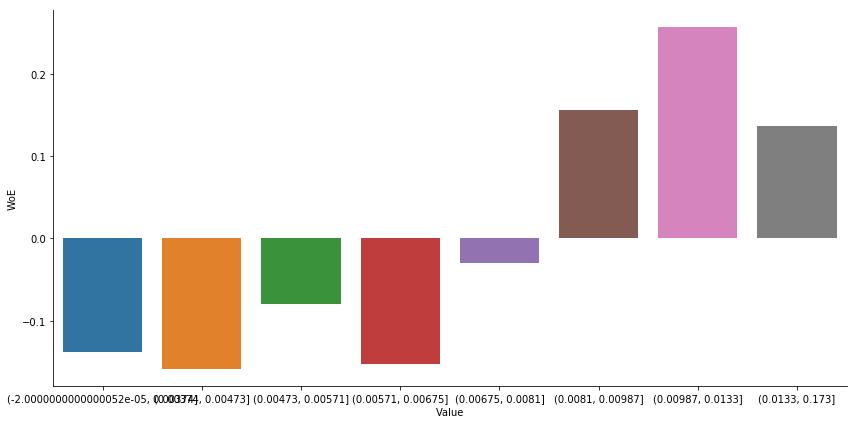

In [18]:
# Divide Jitter:DDP to 8 bins, graph.
woeData['bin_Jitter:DDP'] = (pd.qcut(data['Jitter:DDP'],8))
visualize_woe(woeData, 'bin_Jitter:DDP', 'moderate_disability')

bin_Jitter(%)


<Figure size 432x288 with 0 Axes>

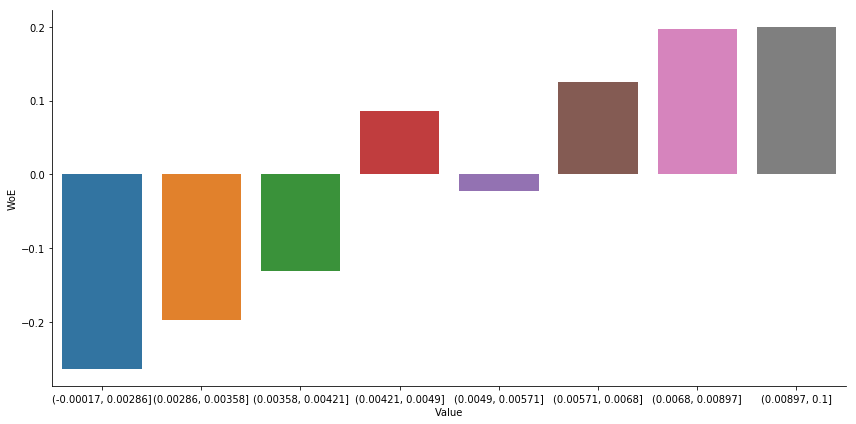

In [19]:
# Divide Jitter(%) to 8 bins, graph.
woeData['bin_Jitter(%)'] = (pd.qcut(data['Jitter(%)'],8))
visualize_woe(woeData, 'bin_Jitter(%)', 'moderate_disability')

bin_Shimmer(dB)


<Figure size 432x288 with 0 Axes>

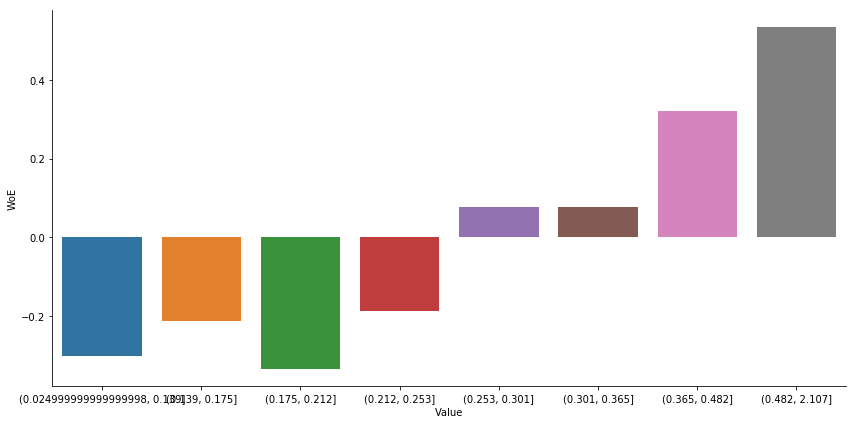

In [20]:
# Divide Shimmer(dB) to 8 bins, graph.
woeData['bin_Shimmer(dB)'] = (pd.qcut(data['Shimmer(dB)'],8))
visualize_woe(woeData, 'bin_Shimmer(dB)', 'moderate_disability')

### 3.3. Grupirati razrede po kriteriju WoE za najjače varijable

bin_age_woe


<Figure size 432x288 with 0 Axes>

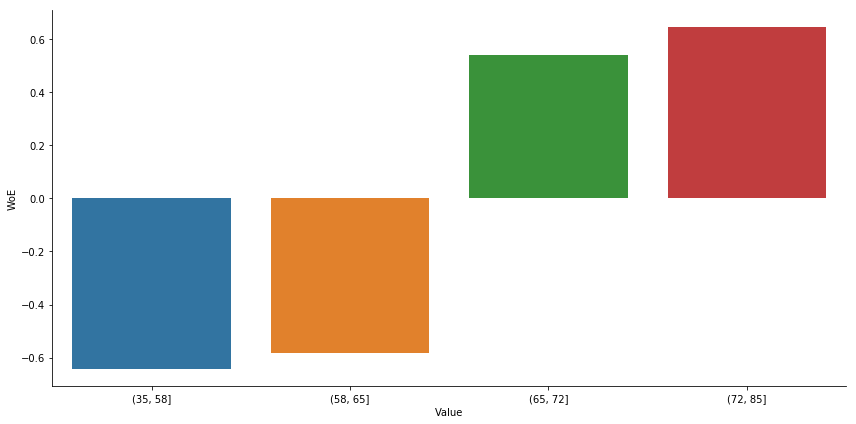

In [21]:
# Combine age bins based on woe values.
woeData['bin_age_woe'] = pd.cut(data['age'], bins=[35, 58, 65, 72, 85])
visualize_woe(woeData, 'bin_age_woe', 'moderate_disability')

bin_Jitter:DDP_woe


<Figure size 432x288 with 0 Axes>

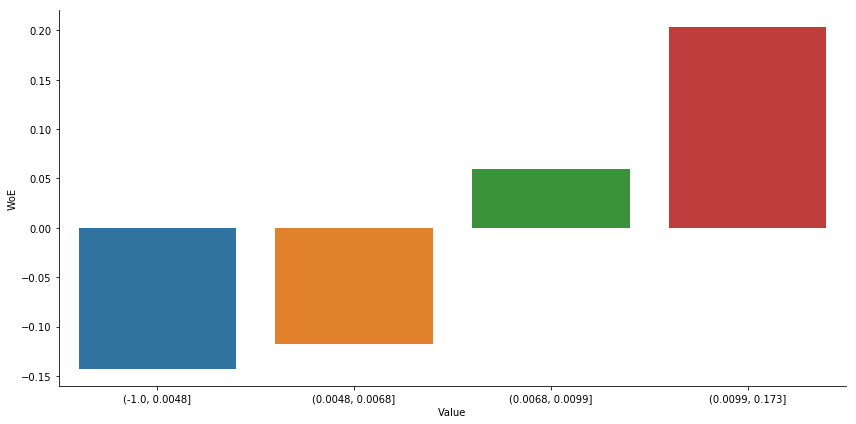

In [22]:
# Combine Jitter:DDP bins based on woe values.
woeData['bin_Jitter:DDP_woe'] = pd.cut(data['Jitter:DDP'], bins=[-1, 0.0048, 0.0068, 0.0099, 0.173])
visualize_woe(woeData, 'bin_Jitter:DDP_woe', 'moderate_disability')

bin_Jitter(%)_woe


<Figure size 432x288 with 0 Axes>

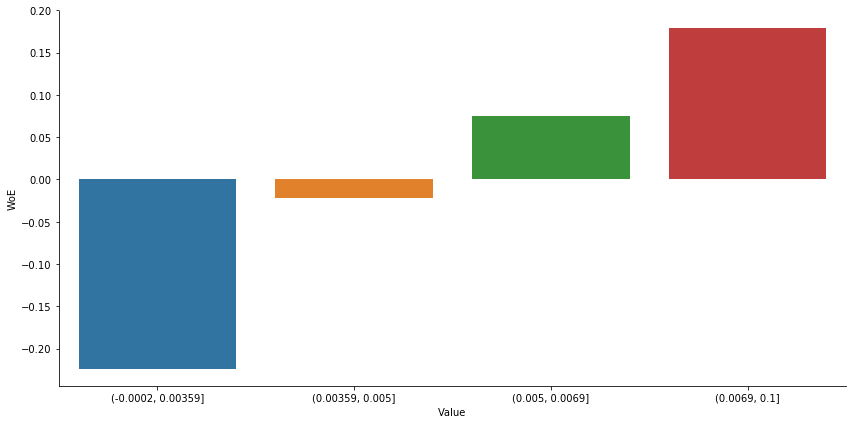

In [23]:
# Combine Jitter(%) bins based on woe values.
woeData['bin_Jitter(%)_woe'] = pd.cut(data['Jitter(%)'], bins=[-0.0002, 0.00359, 0.005, 0.0069, 0.1])
visualize_woe(woeData, 'bin_Jitter(%)_woe', 'moderate_disability')

bin_Shimmer(dB)_woe


<Figure size 432x288 with 0 Axes>

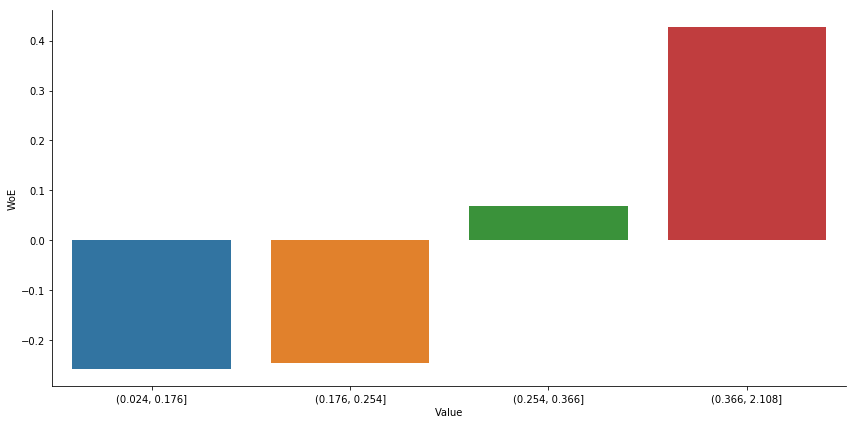

In [24]:
# Combine Shimmer(dB) bins based on woe values.
woeData['bin_Shimmer(dB)_woe'] = pd.cut(data['Shimmer(dB)'], bins=[0.024, 0.176, 0.254, 0.366, 2.108])
visualize_woe(woeData, 'bin_Shimmer(dB)_woe', 'moderate_disability')

### 3.4. Objasniti što ste spoznali temeljem ove analize (profili, uzroci, uzročno posljedične veze)

Analizom podataka izračunate su IV i WoE vrijednosti svih parametara te su odabrane najbolje vrijednosti na temelju IV-a. Dodatno je učinjena WoE analiza za sljedeće atribute: **age**, **Jitter:DDP**, **Jitter(%)**, **Shimmer(dB)** koji su se ujedno pokazali kao najbolji prediktori za određivanje vrijednosti ciljne varijable.

#### age
- IV: **0.83**
- očekivano najveći IV
- pozitivan WoE pojavljuje se za vrijednosti veće od 65 dok je WoE negativan za vrijednost manje od 65
- veoma jak prediktor, velika je vjerojatnost da će subjekt **stariji od 65 godina** imati razvijenu umjerenu invalidnost

#### Jitter:DDP
- IV: **0.40**
- prikazuje promjenu u uzastopnim periodiodima govora u odnosu na snimku s normalnim vrijednostima
- temeljem WoE analize dolazimo do zaključka da DDP vrijednost između od **0.0068** i **0.0099** ukazuje na moguću invalidnost, dok je vrijednost veća od **0.0099** dobar pokazatelj za prisutnost umjerene invalidnosti

#### Jitter(%)
- IV: **0.37**
- prikazuje prosjecnu promjenu frekvencije govora izraženu u postocima
- nešto opčenitiji, ali veoma sličan pokazatelj kao **Jitter:DDP** parametar koji nešto detaljnije opisuje uzastopne periode
- pozitivan WoE za vrijednosti veće od **0.005%**

#### Shimmer(dB)
- IV: **0.35**
- prikazuje promjenu amplitude govora izraženu u decibelima
- WoE analizom pokazalo se kako su vrijednosti promjene amplitude veće od **0.366dB** veoma dobar pokazatelj za prisutnost invalidnosti

#### ostalo
- za većinu dodatnih **Jitter** i **Shimmer** parametara pokazalo se kako također imaju zadovoljavajuću vrijednost IV-a te bi ih bilo moguće ukljućiti u napredniji model
- ostale vrijednosti imaju mali utjecaj na vrijednost ciljne varijable te ih možemo zanemariti

### 3.5. Predložite kako biste riješili problem vezano uz vaš skup podataka temeljem IV, WoE analize (što bi trebalo mijenjati, raditi drugačije, gdje je problem uzrok problema, koji su rizični profili ...)

Ukoliko se prisjetimo sa početka kako je cilj prikupljanja ovog seta podataka bilo određivanje povezanosti između promjena govornih parametara i stupnja uznapredovalosti Parkinsonove bolesti dolazimo do sljedećih zaključaka:

- iako **age** parametar ima najveći utjecaj na ciljnu varijablu ne spada pod promjene parametara govora te je moj prijedlog da ga **zanemarimo** u krajnjoj predikciji
- također kako parametri Jitter:DDP i Jitter(%) opisuju veoma sličnu promjenu, a Jitter:DDP parametar prikazuje nešto detaljnije promjenu frekvencije, predlažem da i **Jitter(%)** parametar **izostavimo** iz modela

Temeljem ove analize i prethodnih zaključaka možemo reći da osoba koja boluje od Parkinsonove bolesti te ima vrijednosti parametra **Jitter:DDP veće od 0.0099** te vrijednosti parametra **Shimmer(dB) veće od 0.366dB** ima **veliki rizik za prisutnost umjerene invalidnosti**.

#### Zaključak

Određivanje i praćenje Parkinsonove bolesti je veoma težak i dugotrajan proces te iako se svakodnevno unaprijeđuju nove metode i dalje radi o relativno nepoznatoj bolesti. Potrebno je pronaći nove, brže i učinkovitije metode otkrivanja bolesti te je analiza promjena govornih parametara definitivno na tom tragu. Smatram da ovaj set podataka može poslužiti za izradu obećavajućeg prediktivnog modela koji bi mogao unaprijediti određivanje stadija Parkinsonove bolesti.